In [2]:
from transformers import AutoTokenizer,DataCollatorForLanguageModeling
from datasets import Dataset, load_dataset
from collections import Counter
import re
from nltk.util import ngrams
from multiprocessing import Pool, cpu_count
import itertools
import pickle
import flashtext
import glob
import psutil
import pandas as pd

def preprocess_text(text):
    if type(text) == list:
        text = ' '.join(text)
    return re.sub('[^a-zäöüß ]', ' ', text.lower())

def prep_count(text):
    tokens = preprocess_text(text).split()
    return tokens

## CC100 dataset

In [48]:
dataset = load_dataset("cc100", lang="de")

Using custom data configuration de-lang=de
Reusing dataset cc100 (/home/andreas/.cache/huggingface/datasets/cc100/de-lang=de/0.0.0/b583dd47b0dd43a3c3773075abd993be12d0eee93dbd2cfe15a0e4e94d481e80)


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text'],
        num_rows: 264959282
    })
})

In [ ]:
text = dataset['train'][:10000000]['text']

In [ ]:
dataset.num_rows

{'train': 264959282}

In [ ]:
step = 1000000
workers = min(8,int(cpu_count()-10))
j = 0
while j < dataset.num_rows['train']+step*workers:
    with Pool(workers) as p:

        results = p.map(prep_count,[dataset['train'][start:start+step]['text'] for start in range(j,j+step*workers,step)])

    results = list(itertools.chain.from_iterable(results))

    with open('cc_100_vocab/count_'+str(j)+'.pkl', 'wb') as handle:
        pickle.dump(Counter(results), handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('cc_100_vocab/text_'+str(j)+'.txt', 'w') as f:
        f.write(' '.join(results))

    del results
    j+= step*workers
    print(j)



8000000
16000000
24000000
32000000
40000000
48000000
56000000
64000000
72000000
80000000
88000000
96000000
104000000
112000000
120000000
128000000
136000000
144000000
152000000
160000000
168000000
176000000
184000000
192000000
200000000
208000000
216000000
224000000
232000000
240000000
248000000
256000000
264000000
272000000
280000000


In [ ]:
dict_path = 'cc_100_vocab'
files = glob.glob(dict_path+"/*.pkl")


In [ ]:
vocab_dict = {}
for file in files:
    with open(file,'rb') as f:
        dict_tmp = dict(pickle.load(f))
        print(len(dict_tmp))
        print('loaded')
        for key in dict_tmp.keys():
            if key in vocab_dict.keys():
                vocab_dict[key] += dict_tmp[key]
            else:
                vocab_dict[key] = dict_tmp[key]

    print('total len')
    print(len(vocab_dict))
    print('finished')

    

2102891
loaded
total len
2102891
finished
2097646
loaded
total len
3169425
finished
2080596
loaded
total len
4020441
finished
2094026
loaded
total len
4756273
finished
2087862
loaded
total len
5418619
finished
2100540
loaded
total len
6025367
finished
2106190
loaded
total len
6588648
finished
2060163
loaded
total len
7116374
finished
2101337
loaded
total len
7616127
finished
2101746
loaded
total len
8091979
finished
2079264
loaded
total len
8552338
finished
2091972
loaded
total len
8995334
finished
2071933
loaded
total len
9421351
finished
2096285
loaded
total len
9833827
finished
2095572
loaded
total len
10231164
finished
2086104
loaded
total len
10618480
finished
2097209
loaded
total len
10994751
finished
0
loaded
total len
10994751
finished
2073941
loaded
total len
11360317
finished
2039143
loaded
total len
11714543
finished
2046018
loaded
total len
12059970
finished
2086161
loaded
total len
12402391
finished
2082478
loaded
total len
12733715
finished
2091506
loaded
total len
130610

In [ ]:
len(vocab_dict)

16052303

In [ ]:
with open(dict_path+'/vocab_word_count.pkl', 'wb') as f:
    pickle.dump(vocab_dict, f)


NameError: name 'dict_path' is not defined

## CC 100

In [3]:
dict_path = 'cc_100_vocab'
with open(dict_path+'/vocab_word_count.pkl', 'rb') as f:
    cc100_vocab = pickle.load(f)

In [ ]:
{k: v for k, v in sorted(cc100_vocab.items(), key=lambda item: item[1])}

{'naappf': 1,
 'hotelaufkommen': 1,
 'parteement': 1,
 'mvoneinander': 1,
 'fruchteiscreme': 1,
 'enwunsch': 1,
 'bestimmungsrahmen': 1,
 'dachwerbeanlagen': 1,
 'stahlmastkonstruktionen': 1,
 'nacktprotesten': 1,
 'messingmetallschließe': 1,
 'handlungszusammen': 1,
 'guanabanasaft': 1,
 'lesertäuschenden': 1,
 'lesertäuscher': 1,
 'soloperdue': 1,
 'onlyfortwo': 1,
 'elternzeitkarten': 1,
 'tonfliesenfußböden': 1,
 'rucksackkino': 1,
 'statusverändernden': 1,
 'lehramtsgesetz': 1,
 'mamazirkel': 1,
 'soloporträts': 1,
 'contentstrategin': 1,
 'süßungswunsch': 1,
 'unfallodysee': 1,
 'nachrüßten': 1,
 'erbringungsgehilfen': 1,
 'gottoms': 1,
 'shinanzou': 1,
 'tythannial': 1,
 'materialfestlegung': 1,
 'hineinangeln': 1,
 'schlafgehe': 1,
 'elternforfamily': 1,
 'interund': 1,
 'grundsätzlichverschiedene': 1,
 'browseraus': 1,
 'kleiuderschrank': 1,
 'gemeinwohlweck': 1,
 'strohhalmbindungen': 1,
 'einzbilden': 1,
 'schlafenzzz': 1,
 'indigenenschutz': 1,
 'finanzphallus': 1,
 'hörsse

## Gutenberg

In [26]:
with open('gutenberg/gutenberg_corpus_complete.txt') as f:
    gutenberg_text = f.read()

gutenberg_vocab = dict(Counter(prep_count(gutenberg_text)))
len(gutenberg_vocab)

159501

In [ ]:
{k: v for k, v in sorted(gutenberg_vocab.items(), key=lambda item: item[1])}

{'görg': 1,
 'aufnem': 1,
 'gewiesne': 1,
 'zeitenfluth': 1,
 'sommerfreuden': 1,
 'respectiren': 1,
 'schnüpfel': 1,
 'kirschenpaar': 1,
 'schelmenzähnchen': 1,
 'stehls': 1,
 'krabb': 1,
 'danske': 1,
 'gothisch': 1,
 'festungswalle': 1,
 'sundes': 1,
 'helsingborg': 1,
 'wälderpracht': 1,
 'pechschwarz': 1,
 'kullen': 1,
 'freundeskreis': 1,
 'eisenpforten': 1,
 'kasematte': 1,
 'durchspähte': 1,
 'volksliede': 1,
 'schwerdts': 1,
 'mannskraft': 1,
 'dänenland': 1,
 'holgers': 1,
 'riesendrucke': 1,
 'lectrices': 1,
 'abconterfeit': 1,
 'gartenheck': 1,
 'beschickten': 1,
 'hinüberhängend': 1,
 'officierchen': 1,
 'bauerntracht': 1,
 'haselbüsche': 1,
 'erdbeerpflanzen': 1,
 'phantasiestück': 1,
 'piquet': 1,
 'engelshauf': 1,
 'aaren': 1,
 'mädchenmund': 1,
 'wohlgewachsne': 1,
 'großgezogen': 1,
 'heckenstäbe': 1,
 'mühlteich': 1,
 'schneelichtes': 1,
 'blumennetz': 1,
 'brautbette': 1,
 'treuerweise': 1,
 'besitzers': 1,
 'mutteraugs': 1,
 'zauberschlösser': 1,
 'siegespalm': 1,


## Generated poems

In [27]:
with open('generated/generated_poems.txt') as f:
    generated_text = f.read()
generated_vocab = dict(Counter(prep_count(generated_text)))
len(generated_vocab)

5672

In [28]:
with open('generated/GPT2_generated_poems.txt') as f:
    gpt2_generated_text = f.read()
gpt2_generated_vocab = dict(Counter(prep_count(gpt2_generated_text)))

with open('generated/GPT3_generated_poems.txt') as f:
    gpt3_generated_text = f.read()
gpt3_generated_vocab = dict(Counter(prep_count(gpt3_generated_text)))


In [ ]:
{k: v for k, v in sorted(generated_vocab.items(), key=lambda item: item[1])}

{'voranzuspielen': 1,
 'schänder': 1,
 'bisher': 1,
 'allerletzte': 1,
 'sagten': 1,
 'gebunden': 1,
 'schergen': 1,
 'ganzem': 1,
 'werfe': 1,
 'seufzern': 1,
 'rinnet': 1,
 'weizen': 1,
 'währt': 1,
 'wol': 1,
 'schier': 1,
 'gartenbeete': 1,
 'längs': 1,
 'grabens': 1,
 'gemessen': 1,
 'mondwärts': 1,
 'zerfließt': 1,
 'zauberkreise': 1,
 'schwülen': 1,
 'fahlen': 1,
 'verjüng': 1,
 'sonnenglut': 1,
 'vieh': 1,
 'weibe': 1,
 'kenn': 1,
 'seltnes': 1,
 'schwiegen': 1,
 'sommertagen': 1,
 'verbrach': 1,
 'entlegne': 1,
 'trabten': 1,
 'lohte': 1,
 'urvertrauen': 1,
 'nützln': 1,
 'ausgeführt': 1,
 'verschmähter': 1,
 'betrübt': 1,
 'unbelohnt': 1,
 'aufgerichtn': 1,
 'teufeln': 1,
 'karg': 1,
 'häufig': 1,
 'verhasst': 1,
 'aufgeregten': 1,
 'wirr': 1,
 'erstorben': 1,
 'gabst': 1,
 'menschentugend': 1,
 'verbürgst': 1,
 'menschentücke': 1,
 'strenge': 1,
 'rätselherde': 1,
 'versöhnungsstätte': 1,
 'heiden': 1,
 'hörten': 1,
 'trifft': 1,
 'früher': 1,
 'seher': 1,
 'himmelshöh': 1,


## Generated words in corpus

In [31]:
def cnt_words_other_vocab(vocab,other_vocab):
    cnt_other_vocab = {}
    if type((vocab)) == dict:
        word_lst = vocab.keys()
    elif type(vocab) == list:
        word_lst = vocab
    elif type(vocab) == str:
        word_lst = vocab.split()
    else:
        raise(Exception)
    for word in word_lst:
        cnt = other_vocab.get(word)
        if cnt is None:
            cnt = 0
        cnt_other_vocab [word] = cnt
    return cnt_other_vocab

gen_in_gutenberg = cnt_words_other_vocab(generated_vocab,gutenberg_vocab)
gen_in_cc100 = cnt_words_other_vocab(generated_vocab,cc100_vocab)

gutenberg_in_cc100 = cnt_words_other_vocab(gutenberg_vocab,cc100_vocab)

In [ ]:
{k: v for k, v in sorted(gen_in_gutenberg.items(), key=lambda item: item[1])}

In [ ]:
{k: v for k, v in sorted(gen_in_cc100.items(), key=lambda item: item[1])}

In [ ]:
{k: v for k, v in sorted(gutenberg_in_cc100.items(), key=lambda item: item[1])}

In [10]:

gpt2_gen_in_gutenberg = cnt_words_other_vocab(gpt2_generated_vocab,gutenberg_vocab)
gpt2_gen_in_cc100 = cnt_words_other_vocab(gpt2_generated_vocab,cc100_vocab)

gpt3_gen_in_gutenberg = cnt_words_other_vocab(gpt3_generated_vocab,gutenberg_vocab)
gpt3_gen_in_cc100 = cnt_words_other_vocab(gpt3_generated_vocab,cc100_vocab)


In [43]:
def cnt_word_in_every_vocab(vocab,corpus_lst):
    cnt_every_vocab = {}
    if type((vocab)) == dict:
        word_lst = vocab.keys()
    elif type(vocab) == list:
        word_lst = vocab
        print('list')
    elif type(vocab) == str:
        word_lst = vocab.split()
    else:
        raise(Exception)
    for word in word_lst:
        sum = 0
        for corpus in corpus_lst:
            val = corpus.get(word)
            try:
                sum += val
            except:
                pass

        cnt_every_vocab[word] = sum
    return cnt_every_vocab

gpt2_gen_in_all = cnt_word_in_every_vocab(gpt2_generated_vocab,[gutenberg_vocab,cc100_vocab])
gpt3_gen_in_all = cnt_word_in_every_vocab(gpt3_generated_vocab,[gutenberg_vocab,cc100_vocab])

In [47]:
gpt2_gen_words_in_all = [gpt2_gen_in_all[word] for word in prep_count(gpt2_generated_text)]
gpt3_gen_words_in_all = [gpt3_gen_in_all[word] for word in prep_count(gpt3_generated_text)]

In [85]:
gpt2_gen_words_in_all.count(0)

138

In [41]:
len(gpt2_generated_text.split())

52554

In [14]:
{k: v for k, v in sorted(gpt2_gen_in_all.items(), key=lambda item: item[1])}

{'nützln': 0,
 'aufgerichtn': 0,
 'rätselherde': 0,
 'versöhnungsstätte': 0,
 'mäuschenrennen': 0,
 'wiedergewebt': 0,
 'teufelsspein': 0,
 'wüppeln': 0,
 'hähähähn': 0,
 'erlüften': 0,
 'niederzwungen': 0,
 'homeof': 0,
 'tiefverborgnem': 0,
 'purpurflor': 0,
 'schöpfungsseele': 0,
 'götterhass': 0,
 'vogelweib': 0,
 'verhallst': 0,
 'browsin': 0,
 'saphirrangel': 0,
 'hineingehauchten': 0,
 'allversager': 0,
 'erdbeglückung': 0,
 'kindheitsfrüchte': 0,
 'treuefest': 0,
 'sternenpforten': 0,
 'euchotiveire': 0,
 'wäldedübel': 0,
 'sorglic': 0,
 'lockenkuß': 0,
 'geyerht': 0,
 'schlafesdunkel': 0,
 'sädelbrief': 0,
 'lebensstädte': 0,
 'geirzeth': 0,
 'engelküssen': 0,
 'lichtevollen': 0,
 'verdröhnen': 0,
 'streuteppich': 0,
 'jubelglocken': 0,
 'zösig': 0,
 'füen': 0,
 'strahlenstrahlen': 0,
 'erdenfahre': 0,
 'unzutastbar': 0,
 'flachsverdellen': 0,
 'totgeschunden': 0,
 'götzenhand': 0,
 'herzensodem': 0,
 'vermählets': 0,
 'aimese': 0,
 'schürts': 0,
 'tagbefehl': 0,
 'hirnger': 0

159501
0.4822226819894546
22
21


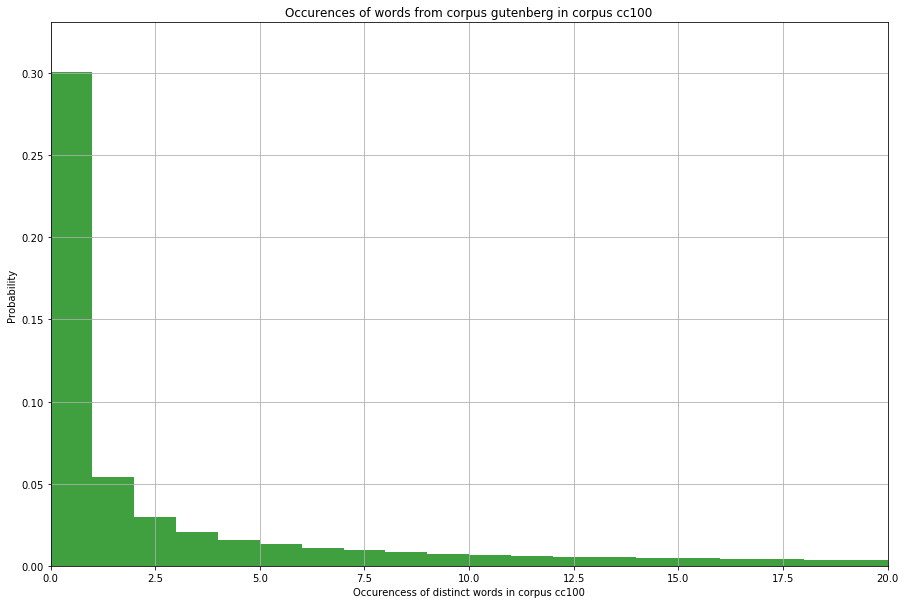

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(vocab,corpus,other_corpus,max_cnt = 20):
    x = [v if v < max_cnt else max_cnt+1 for v in vocab.values() ]
    print(len(x))
    # the histogram of the data
    hist,bins = np.histogram(np.asarray(x),bins = max_cnt+1,density=True)
    print(max(hist))
    n, bins, patches = plt.hist(x, max_cnt+1, density=True, facecolor='g', alpha=0.75)

    print(len(bins))
    print(len(hist))
    plt.rcParams["figure.figsize"] = (15,10)
    plt.xlabel('Occurencess of distinct words in corpus '+other_corpus)
    plt.ylabel('Probability')
    plt.title('Occurences of words from corpus ' + corpus +  ' in corpus '+other_corpus)
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.xlim(0, max_cnt)
    plt.ylim(0, max(hist[:max_cnt])*1.1)
    plt.grid(True)
    #plt.bar(bins,hist)
    plt.show()

    
plot_histogram(gutenberg_in_cc100,'gutenberg','cc100')

5672
0.9255994358251057
22
21


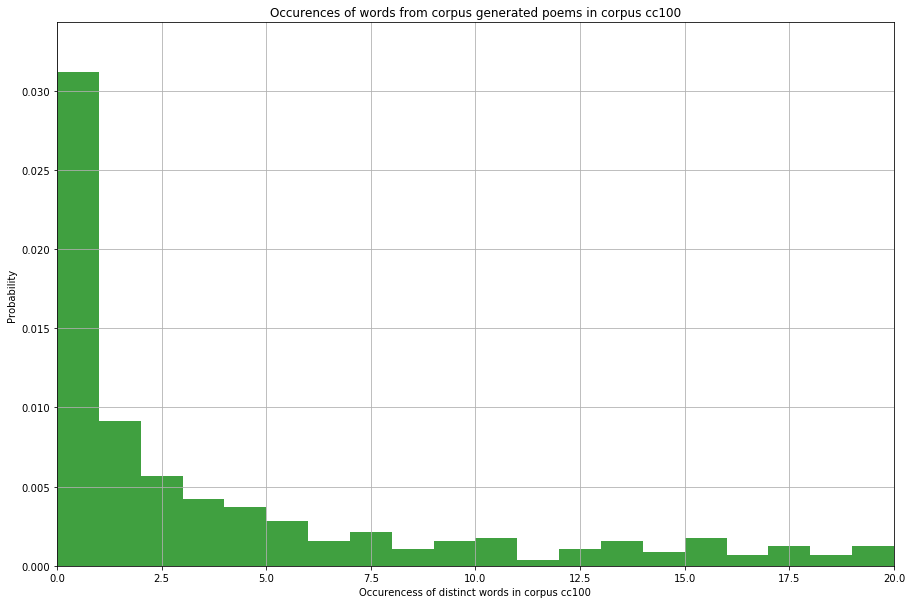

In [106]:
plot_histogram(gen_in_cc100,'generated poems','cc100',max_cnt=20)

5672
0.7609308885754584
22
21


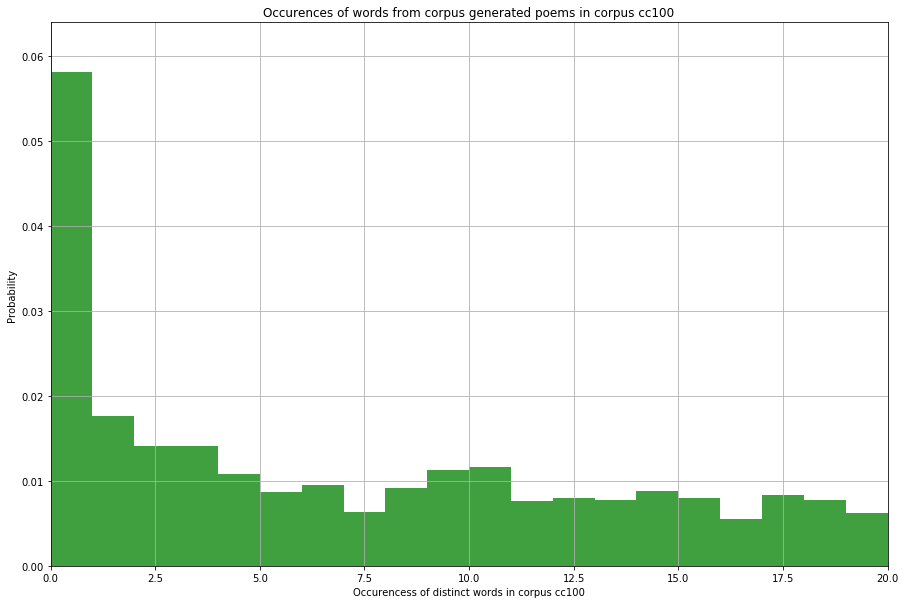

In [107]:
plot_histogram(gen_in_gutenberg,'generated poems','cc100')

5362
0.9386422976501305
22
21


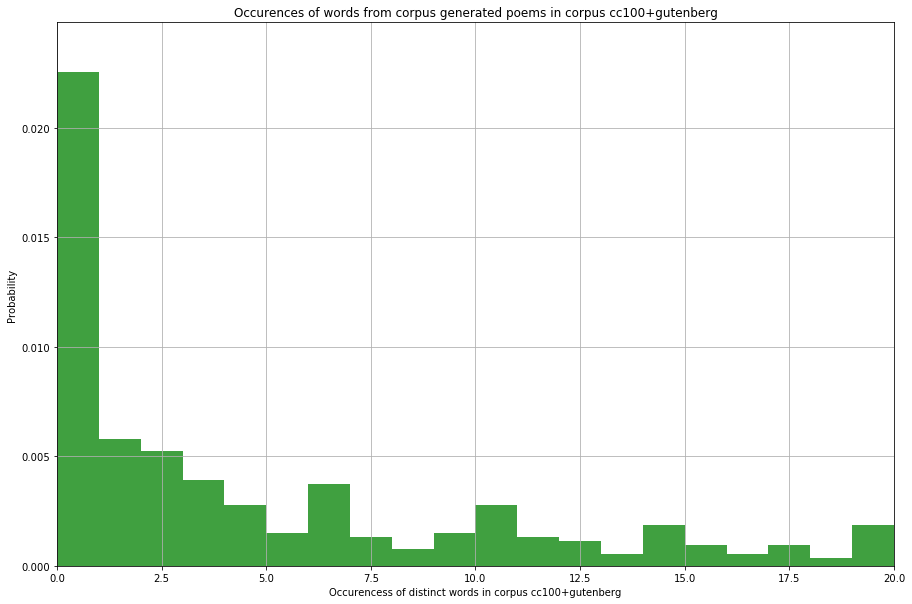

In [108]:
plot_histogram(gpt2_gen_in_all,'generated poems','cc100+gutenberg')

1298
0.987673343605547
22
21


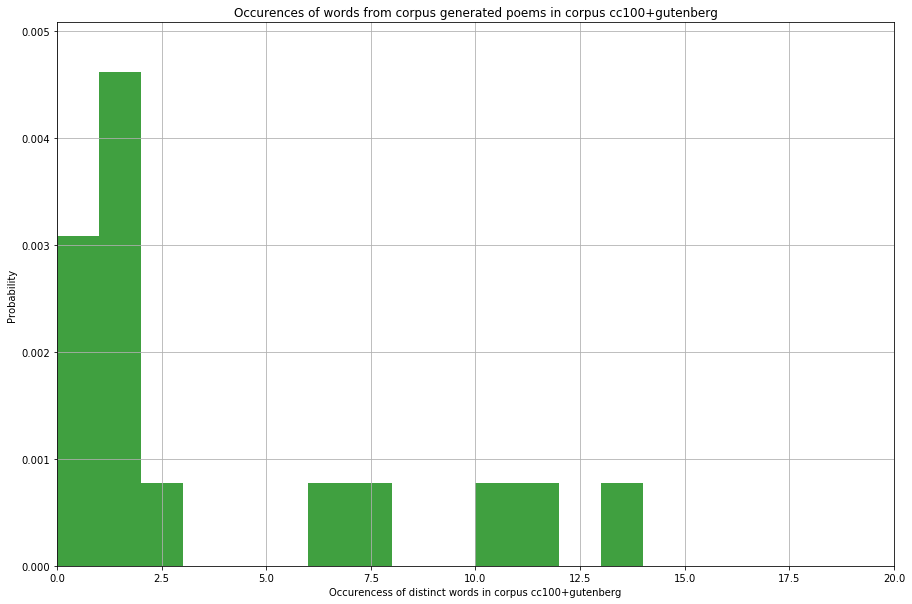

In [109]:
plot_histogram(gpt3_gen_in_all,'generated poems','cc100+gutenberg')

In [137]:

def plot_histogram_word_level(vocab,corpus,other_corpus,max_cnt = 20,bin_factor=1):
    density = True
    x = [v if v < max_cnt else max_cnt+1 for v in vocab]
    print(len(x))
    # the histogram of the data
    hist,bins = np.histogram(np.asarray(x),bins = int((max_cnt+1)*bin_factor),density=density)
    print(max(hist))
    n, bins, patches = plt.hist(x, int((max_cnt+1)*bin_factor), density=density, facecolor='g', alpha=0.75)

    print(len(bins))
    print(len(hist))
    plt.rcParams["figure.figsize"] = (15,10)
    plt.xlabel('Occurencess of words in corpus '+other_corpus)
    plt.ylabel('Probability')
    plt.title('Occurences of words from corpus ' + corpus +  ' in corpus '+other_corpus)
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.xlim(0, max_cnt)
    plt.ylim(0, max(hist[:int(max_cnt*bin_factor)-1])*1.1)
    plt.grid(True)
    #plt.bar(bins,hist)
    plt.show()


47853
0.9918500407497962
22
21


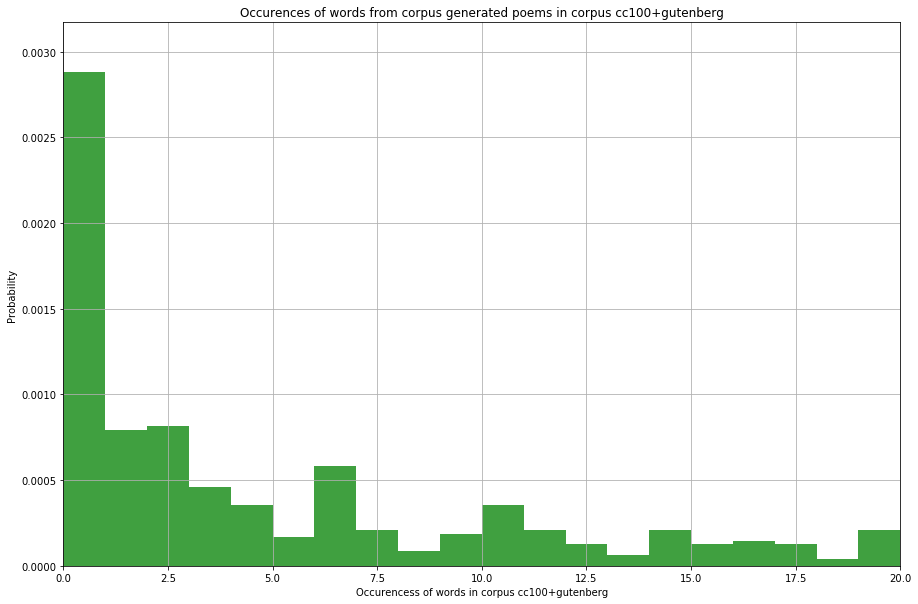

In [111]:
plot_histogram_word_level(gpt2_gen_words_in_all,'generated poems','cc100+gutenberg')

6858
0.9970836978710994
22
21


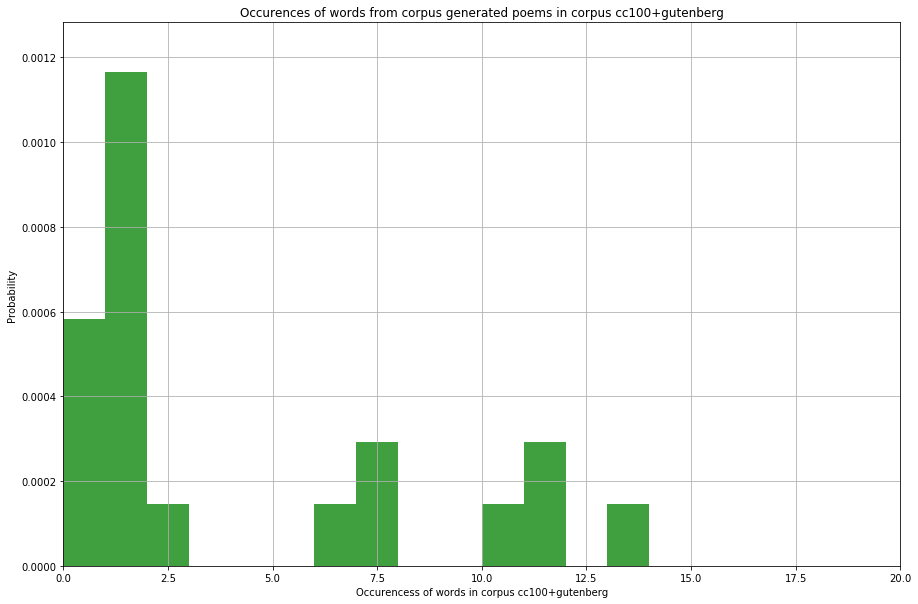

In [112]:
plot_histogram_word_level(gpt3_gen_words_in_all,'generated poems','cc100+gutenberg')

# Hölderlin Schiller

In [155]:
with open('gutenberg/training_2/gpt2_training_gutenberg_only_schiller_no_train.txt') as f:
    schiller_text = f.read()
schiller_vocab = dict(Counter(prep_count(schiller_text)))

with open('gutenberg/training_2/gpt2_training_gutenberg_no_schiller_train.txt') as f:
    no_schiller_text = f.read()
no_schiller_vocab = dict(Counter(prep_count(no_schiller_text)))

with open('gutenberg/training_2/gpt2_training_gutenberg_only_hoelderlin_no_train.txt') as f:
    hoelderlin_text = f.read()

hoelderlin_vocab = dict(Counter(prep_count(hoelderlin_text)))

with open('gutenberg/training_2/gpt2_training_gutenberg_no_hoelderlin_train.txt') as f:
    no_hoelderlin_text = f.read()
no_hoelderlin_vocab = dict(Counter(prep_count(no_hoelderlin_text)))

In [158]:
schiller_in_train = cnt_words_other_vocab(schiller_vocab,no_schiller_vocab)
hoelderlin_in_train = cnt_words_other_vocab(hoelderlin_vocab,no_hoelderlin_vocab)

schiller_words_in_train = [schiller_in_train[word] for word in prep_count(schiller_text)]
hoelderlin_words_in_train = [hoelderlin_in_train[word] for word in prep_count(hoelderlin_text)]

11467
0.012414344590665195
11
10


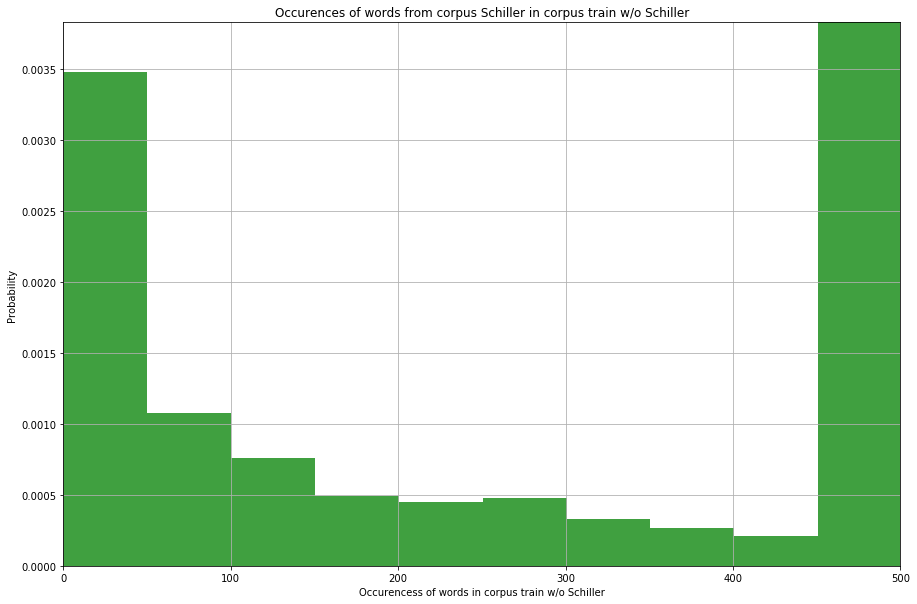

In [163]:
plot_histogram_word_level(schiller_words_in_train,'Schiller','train w/o Schiller',max_cnt=500,bin_factor=0.02)

15630
0.013541694601839196
11
10


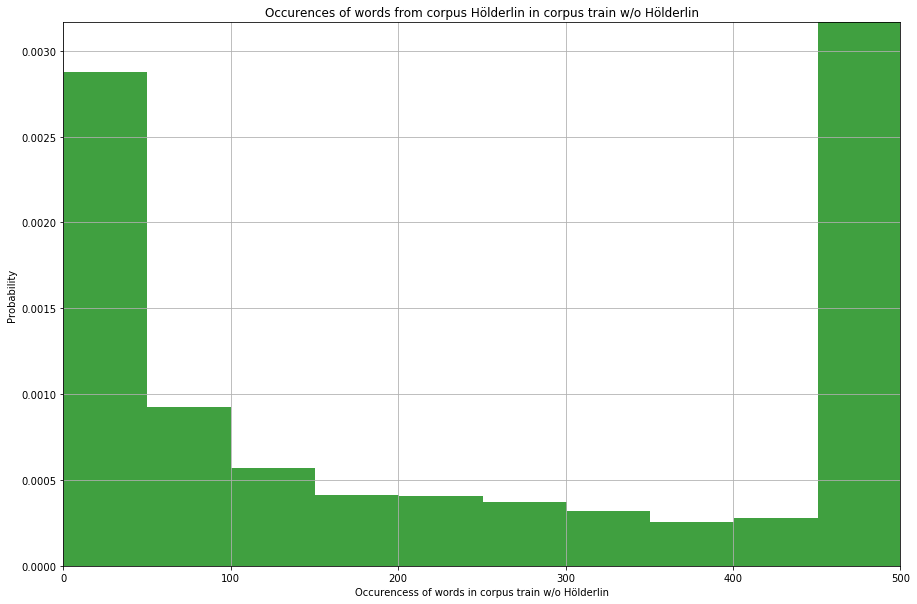

In [164]:
plot_histogram_word_level(hoelderlin_words_in_train,'Hölderlin','train w/o Hölderlin',max_cnt=500,bin_factor=0.02)

3843
0.5758521988030185
42
41


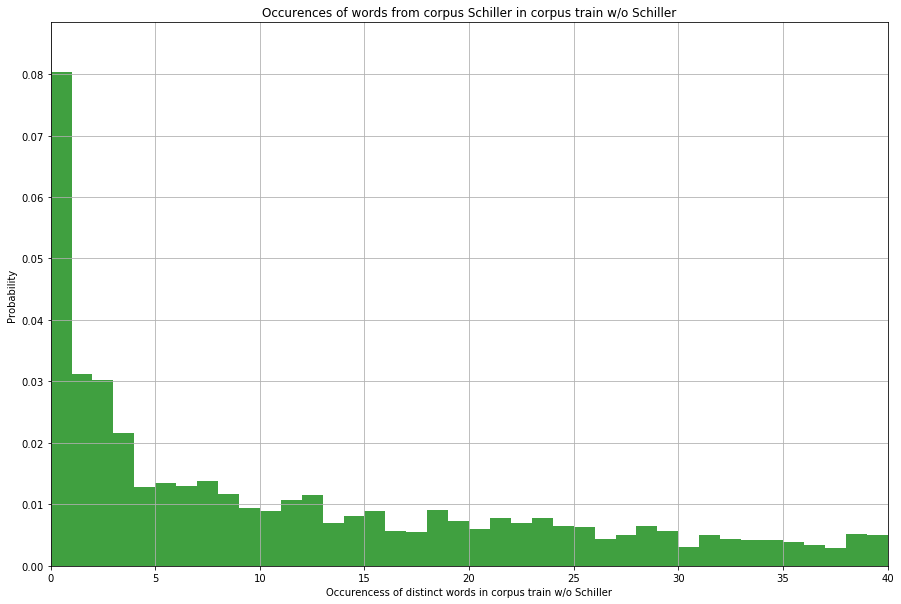

In [161]:
plot_histogram(schiller_in_train,'Schiller','train w/o Schiller',max_cnt=40)

3717
0.5614743072370191
42
41


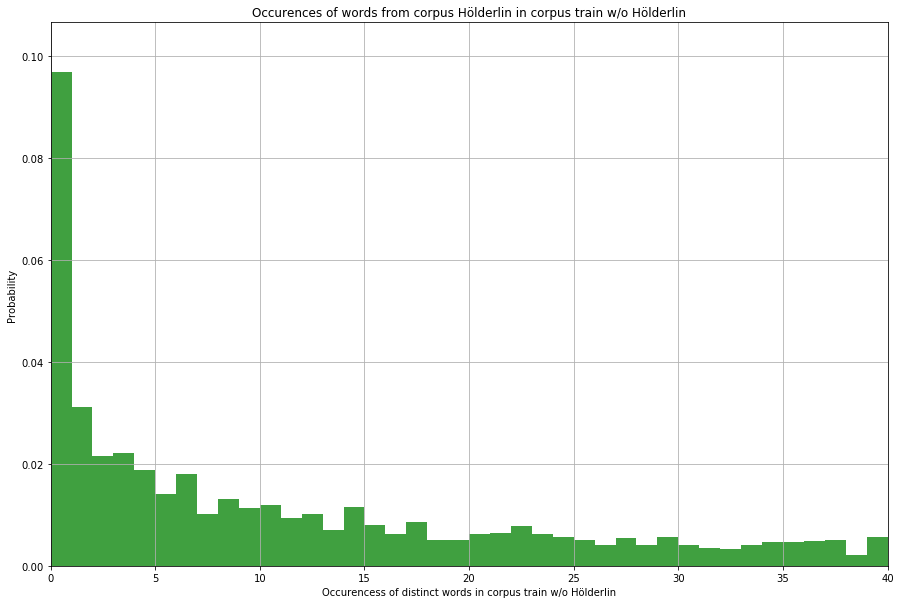

In [162]:
plot_histogram(hoelderlin_in_train,'Hölderlin','train w/o Hölderlin',max_cnt=40)